In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import skimage
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import ImageColor

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from watermark import watermark
print(watermark())
print(watermark(packages="pandas,numpy,matplotlib,skimage,PIL"))

Last updated: 2025-06-13T15:16:01.025322-07:00

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.3.0

Compiler    : MSC v.1943 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores   : 72
Architecture: 64bit

pandas    : 2.2.3
numpy     : 2.1.2
matplotlib: 3.10.3
skimage   : 0.25.2
PIL       : 11.2.1



## Load Data

In [2]:
roi_path = "aligned_roi.tif"
pnts_path = 'points_w_neg_ctrl_ch_488_pos_0_cell4_lf6.0_wf1.5_sf0.0_dr0.csv'
barcodes_path = 'barcodes_unfiltered_w_neg_ctrl_ch_488_pos_0_cell4_lf6.0_wf1.5_sf0.0_dr0.csv'

In [3]:
aligned_stack = skimage.io.imread(roi_path)
#aligned_stack = aligned_stack_[1:81, :, :]
aligned_stack_normed = aligned_stack/np.max(aligned_stack)
pnts = pd.read_csv(pnts_path)
barcodes = pd.read_csv(barcodes_path)

In [4]:
xstart_global = 992
ystart_global = 732

## Get colors

In [5]:
colors_inna_hex = [
    "#F59C62",
    "#D98DC4",
    "#FAE255",
    "#4F9EC4",
    "#F4705A",
    "#A3588D",
    "#84DED8",
    "#7DC899",
    "#C4ECFF",
    "#CCAD42",
    "#FFBDC0",
    "#9C9BDE",
    "#3E8A86",
    "#F7E8B2",
    "#BF6868",
    "#D3DD29",
    "#7271AE",
    "#912A2A",
    "#27598B",
    "#BAC7CC"
]
colors_inna_rbg = [ImageColor.getcolor(c, "RGB") for c in colors_inna_hex]
normed_colors = np.array(colors_inna_rbg)/255

In [6]:
colors_inna_rbg

[(245, 156, 98),
 (217, 141, 196),
 (250, 226, 85),
 (79, 158, 196),
 (244, 112, 90),
 (163, 88, 141),
 (132, 222, 216),
 (125, 200, 153),
 (196, 236, 255),
 (204, 173, 66),
 (255, 189, 192),
 (156, 155, 222),
 (62, 138, 134),
 (247, 232, 178),
 (191, 104, 104),
 (211, 221, 41),
 (114, 113, 174),
 (145, 42, 42),
 (39, 89, 139),
 (186, 199, 204)]

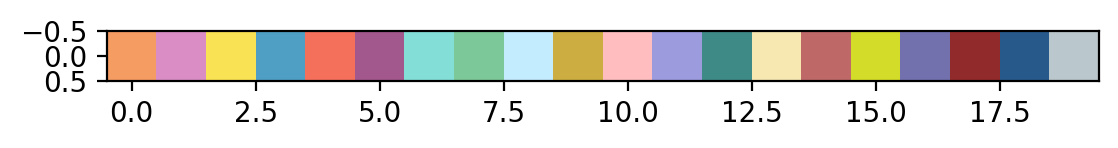

In [7]:
plt.imshow(np.array([colors_inna_rbg]))

In [8]:
def scale_to_color_vector(grey_scale_img, rgb_code):
    img_rgb = np.zeros(list(np.shape(grey_scale_img)) + [3])
    for c in range(3):
        img_rgb[:,:,c] = grey_scale_img*rgb_code[c]/255
    return img_rgb    

def get_roi_pnts(pnts, xstart, xend, ystart, yend):
    roi_pnts = pnts.loc[(pnts["x"] > xstart) & (pnts["x"] < xend) & (pnts["y"] > ystart) & (pnts["y"] < yend)]
    roi_pnts.loc[:, "x"] -= (xstart+1)
    roi_pnts.loc[:, "y"] -= (ystart+1)
    return roi_pnts

def get_hyb_roi_pnts(pnts, hyb, xstart, xend, ystart, yend):
    hyb_pnts = pnts.loc[pnts["hyb"] == hyb]
    return get_roi_pnts(hyb_pnts, xstart, xend, ystart, yend)
    

# Plot Fig 1B

In [9]:
search_radius = 3*np.sqrt(20/30)

def plot_rounds_strip(aligned_normed_stack, pnts, xstart_roi, xend_roi, ystart_roi, yend_roi, xstart_global, xend_global, ystart_global, yend_global, spacing):
    roi = aligned_normed_stack[:,ystart_roi:yend_roi,xstart_roi:xend_roi]
    print(np.shape(roi))
    bc_round_strip = np.ones([4*(yend_roi-ystart_roi) + 3*spacing, xend_roi-xstart_roi, 3])
    fig, ax = plt.subplots(4,1,figsize=(8,20))
    round_ims = []
    for barcoding_round in [4,3,2,1]:
        hyb_start = 20*(barcoding_round-1)
        pseudo_colored_round = scale_to_color_vector(roi[hyb_start,:,:], colors_inna_rbg[19])
        for pc, hyb in enumerate(range(hyb_start+1,hyb_start+20)):
            pseudo_colored_round += scale_to_color_vector(roi[hyb,:,:], colors_inna_rbg[pc-1])
        normed_round = pseudo_colored_round**2
        ax[barcoding_round-1].imshow(pseudo_colored_round/np.max(pseudo_colored_round.sum(axis=2)))
        round_ims.append(pseudo_colored_round)
        ax[barcoding_round-1].tick_params(left = False, bottom = False, labelleft = False, labelbottom=False)

        
        for hyb in range(hyb_start+1,hyb_start+1+20):
            roi_hyb_pnts = get_hyb_roi_pnts(pnts, hyb, xstart_global, xend_global, ystart_global, yend_global)
            pc = hyb % 20
            if pc == 0:
                pc = 20
            for rownum, row in roi_hyb_pnts.iterrows():
                c = plt.Circle((row.x,row.y), radius=0.2, color=normed_colors[pc-1], fill=True, linewidth=3)
                if pc-1 >= 10:
                    ax[barcoding_round-1].text(row.x-0.14,row.y+0.08, pc, color='k', size='xx-large')
                else:
                    ax[barcoding_round-1].text(row.x-0.07,row.y+0.08, pc, color='k', size='xx-large')
                ax[barcoding_round-1].add_patch(c)
        
    print("done")    
    return round_ims

(80, 3, 4)
done


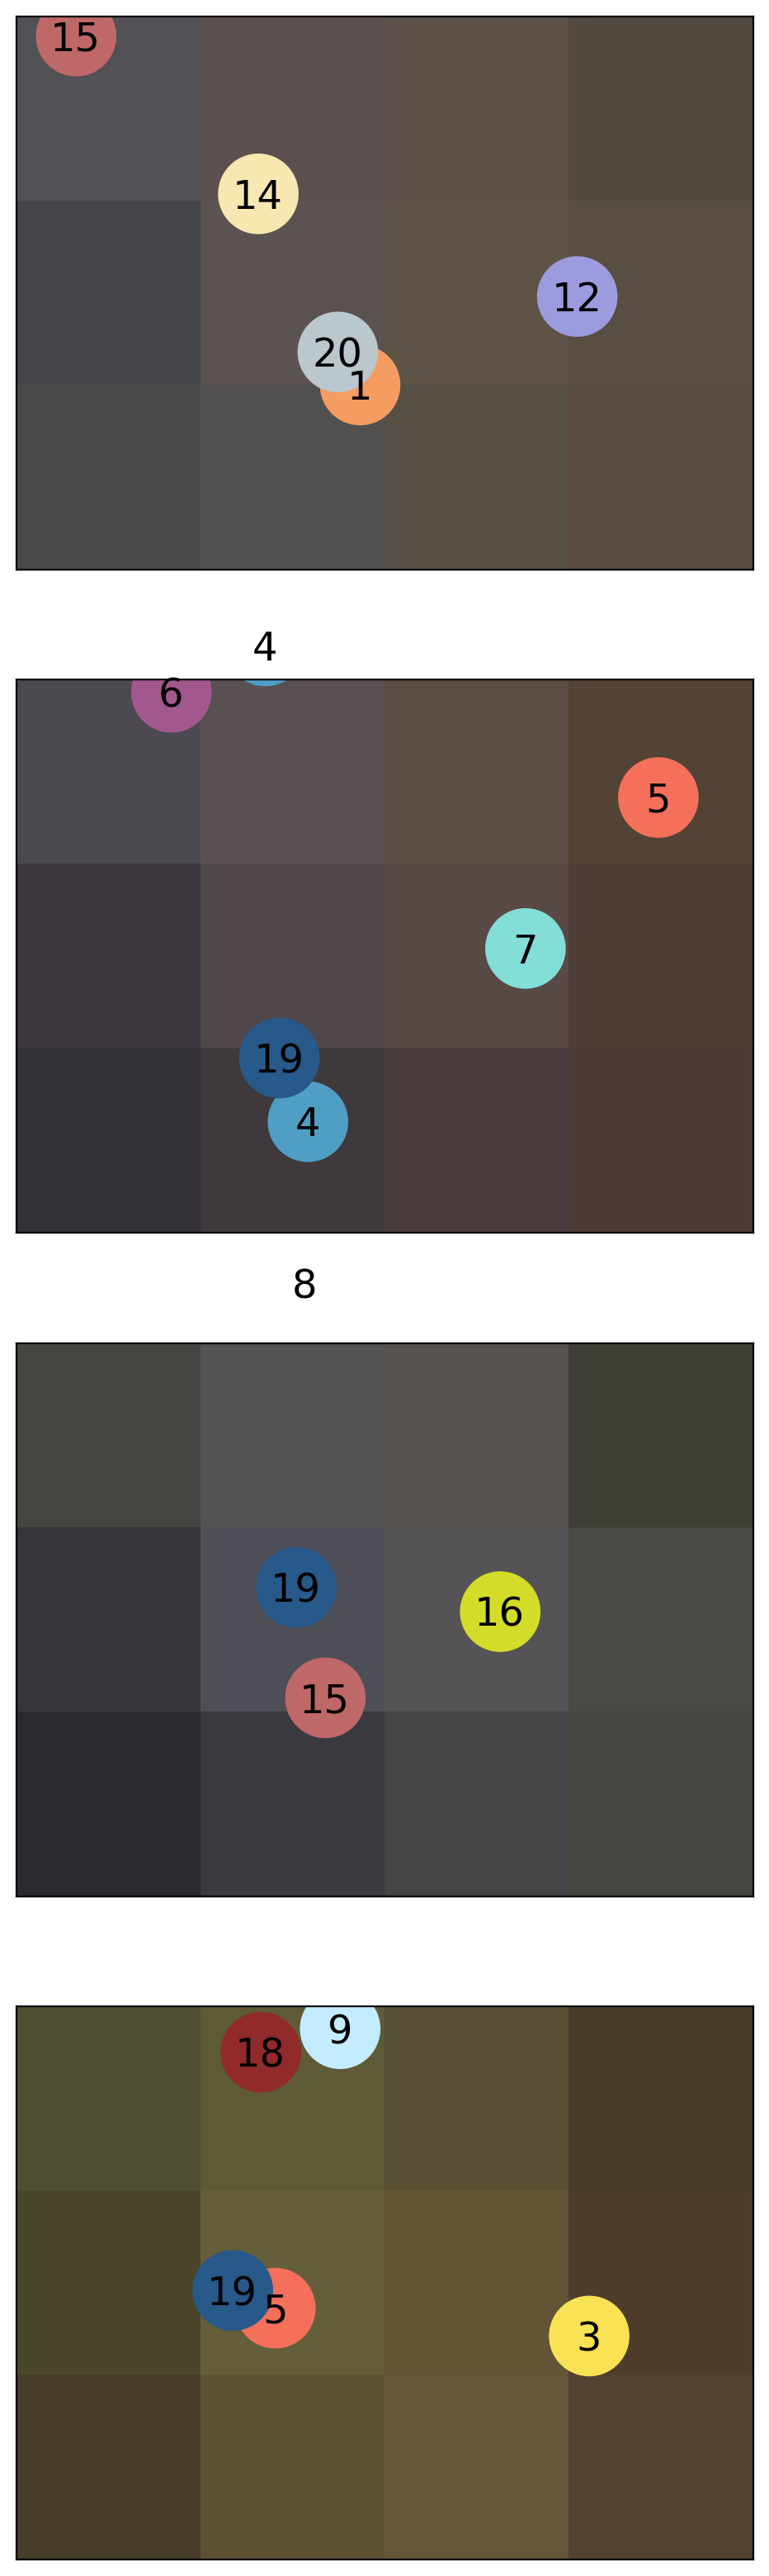

In [10]:
xstart_global = 994
xend_global = 998
ystart_global = 733
yend_global = 736

xstart_roi = 2
xend_roi = 6
ystart_roi = 1
yend_roi = 4
spacing = 1

round_ims=plot_rounds_strip(aligned_stack_normed, pnts, xstart_roi, xend_roi, ystart_roi, yend_roi, xstart_global, xend_global, ystart_global, yend_global, spacing)

In [11]:
roi_pnts = get_roi_pnts(pnts, xstart_global, xend_global, ystart_global, yend_global)
roi_pnts.reset_index(inplace=True)

## Take a closer look at the barcodes to get their costs

In [12]:
ald = roi_pnts.loc[[1,9,13,15]]
print(ald)
6*(np.var(ald.x, ddof=1)+np.var(ald.y, ddof=1)) + 1.6*np.var(np.log2(ald.w),ddof=1)

    index  hyb         x         y     s            w  pos  coeff  decoded
1   17805   12  2.545141  1.019458  1.06  1851.893878    1     12     1649
9   38836   27  2.263762  0.957479  1.06  1719.114547    2      7     1649
13  84115   56  2.126651  0.956291  1.06  2307.523643    3     16     1649
15  96111   63  2.609739  1.287371  1.06  1267.786151    4      3     1649


np.float64(0.6683414676552126)

In [13]:
cp1 = roi_pnts.loc[[0,10,12,16]]
print(cp1)
6*(np.var(cp1.x,ddof=1)+np.var(cp1.y,ddof=1)) + 1.6*np.var(np.log2(cp1.w),ddof=1)

     index  hyb         x         y     s            w  pos  coeff  decoded
0      148    1  1.365895  1.499731  1.06  1093.622527    1      1     1455
10   56216   39  0.927260  1.552482  1.06  1040.187404    2     19     1455
12   82962   55  1.177291  1.424266  1.06  3119.914974    3     15     1455
16  101112   65  0.905421  1.136267  1.06  3638.583923    4      5     1455


np.float64(1.9782807586942677)

In [14]:
cp = roi_pnts.loc[[2,6,14,19]]
print(cp)
6*(np.var(cp.x, ddof=1)+np.var(cp.y, ddof=1)) + 1.6*np.var(np.log2(cp.w), ddof=1)

     index  hyb         x         y         s            w  pos  coeff  \
2    20859   14  0.813160  0.462355  1.060000  1875.904316    1     14   
6    34838   24  1.082809  1.897609  1.016895  1112.715001    2      4   
14   88576   59  1.020392  0.824555  1.060000  4017.331784    3     19   
19  119617   79  0.674652  1.040219  1.028886  1190.251354    4     19   

    decoded  
2        87  
6        87  
14       87  
19       87  


np.float64(3.6048902987100355)

In [15]:
sp_cp = roi_pnts.loc[[4,6,14,16]]
print(sp_cp)
6*(np.var(sp_cp.x, ddof=1)+np.var(sp_cp.y, ddof=1)) + 1.6*np.var(np.log2(sp_cp.w), ddof=1)

     index  hyb         x         y         s            w  pos  coeff  \
4    29493   20  1.244955  1.320371  1.060000  1343.925052    1      0   
6    34838   24  1.082809  1.897609  1.016895  1112.715001    2      4   
14   88576   59  1.020392  0.824555  1.060000  4017.331784    3     19   
16  101112   65  0.905421  1.136267  1.060000  3638.583923    4      5   

    decoded  
4         0  
6        87  
14       87  
16     1455  


np.float64(2.8085126587073286)

In [16]:
sp_cp = roi_pnts.loc[[3,5,10,11]]
print(sp_cp)
6*(np.var(sp_cp.x)+np.var(sp_cp.y)) + 1.6*np.var(np.log2(sp_cp.w))

    index  hyb         x         y     s            w  pos  coeff  decoded
3   22095   15 -0.176198 -0.393557  1.06  1428.575969    1     15        0
5   34836   24  0.850597 -0.683991  1.06  2906.075129    2      4        0
10  56216   39  0.927260  1.552482  1.06  1040.187404    2     19     1455
11  72375   48  1.067407 -0.825469  1.06  1447.777318    3      8        0


np.float64(7.453994468437518)

## Plot Figure 1A Block-Pseudocolor grid

In [17]:
xstart = 992
xend = 998
ystart = 732
yend = 738

In [18]:
roi_pnts = get_roi_pnts(pnts, xstart_global, xend, ystart, yend)
roi_pnts.reset_index(inplace=True)

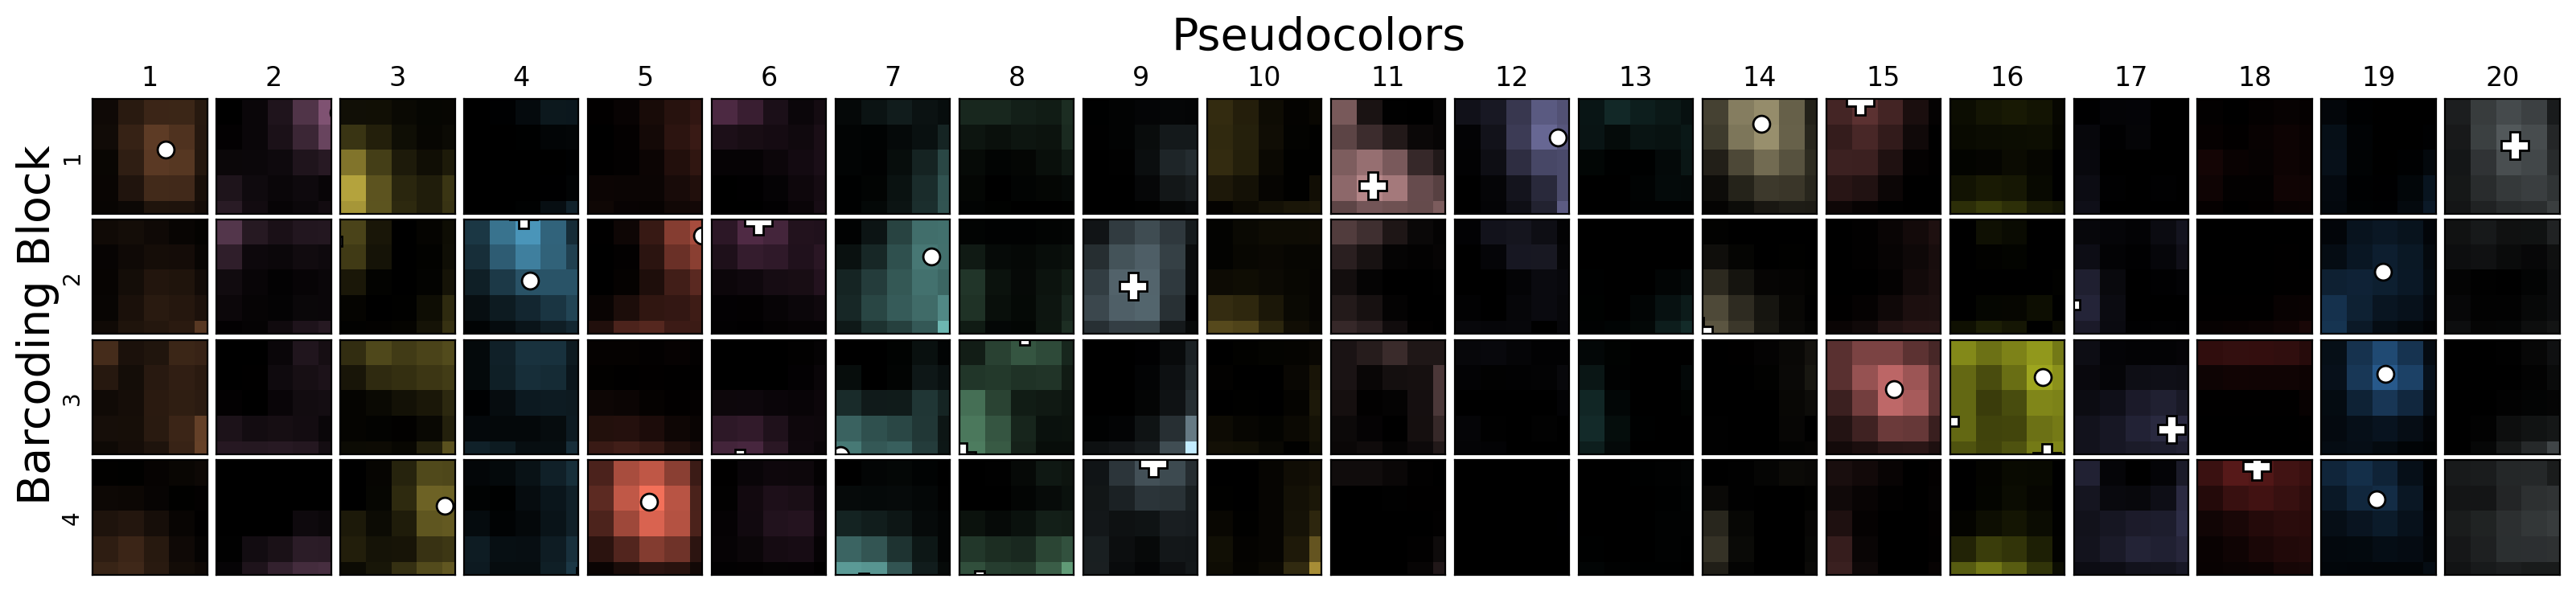

In [21]:
mpl.rcParams['pdf.fonttype']=42

roi = aligned_stack
fig, ax = plt.subplots(4,20,figsize=(18,4))
fig.suptitle("Pseudocolors",size=20,x=0.47)
for pc in range(20):
    ax[0,pc].set_title(pc+1)

fig.supylabel("Barcoding Block",size=20)
for bb in range(4):
    ax[bb,0].set_ylabel(bb+1)

#roi = aligned_normed_stack[:,ystart:yend,xstart:xend]

roi_pnts = get_roi_pnts(pnts, xstart, xend+1, ystart, yend+1)
roi_pnts.reset_index(inplace=True)



for barcoding_round in [4,3,2,1]:
    hyb_start = 20*(barcoding_round-1)
    pseudo_colored_round = scale_to_color_vector(roi[hyb_start,:,:], colors_inna_rbg[19])
    ax[barcoding_round-1, 0].imshow(pseudo_colored_round/np.max(roi))
    ax[barcoding_round-1,0].tick_params(left = False, bottom = False, labelleft = False, labelbottom=False)
    for pc, hyb in enumerate(range(hyb_start,hyb_start+20)):
        pseudo_colored_round = scale_to_color_vector(roi[hyb,:,:], colors_inna_rbg[pc])
        ax[barcoding_round-1, pc].imshow(pseudo_colored_round/np.max([np.max(roi[hyb,:,:]), 2000]))
        ax[barcoding_round-1, pc].tick_params(left = False, bottom = False, labelleft = False, labelbottom=False)
        
        hyb_pnts = roi_pnts.loc[roi_pnts.hyb == hyb+1]
        if any((hyb_pnts.decoded != 0) & (hyb_pnts.decoded < 3335)):
            ax[barcoding_round-1, pc].plot(hyb_pnts.loc[(hyb_pnts.decoded != 0) & (hyb_pnts.decoded < 3335), "x"], hyb_pnts.loc[(hyb_pnts.decoded != 0) & (hyb_pnts.decoded < 3335), "y"], 
                                           linestyle='None',marker='.',markerfacecolor="w", markeredgecolor="k", markersize=15,
                                          label="On-target")
        if any(hyb_pnts.decoded == 0):
            ax[barcoding_round-1, pc].plot(hyb_pnts.loc[hyb_pnts.decoded == 0, "x"], hyb_pnts.loc[hyb_pnts.decoded == 0, "y"], 
                                           linestyle='None',marker='P',markerfacecolor="w", markeredgecolor="k", markersize=12,
                                          label="Not decoded")
        
        
        ax[barcoding_round-1, pc].set_xlim(0.5,5)
        ax[barcoding_round-1, pc].set_ylim(0.5,5)
        ax[barcoding_round-1, pc].invert_yaxis()
plt.subplots_adjust(left=0.045,top=0.85,wspace=0.01, hspace=0.05)
plt.savefig('fig1A.pdf')

## Get legend

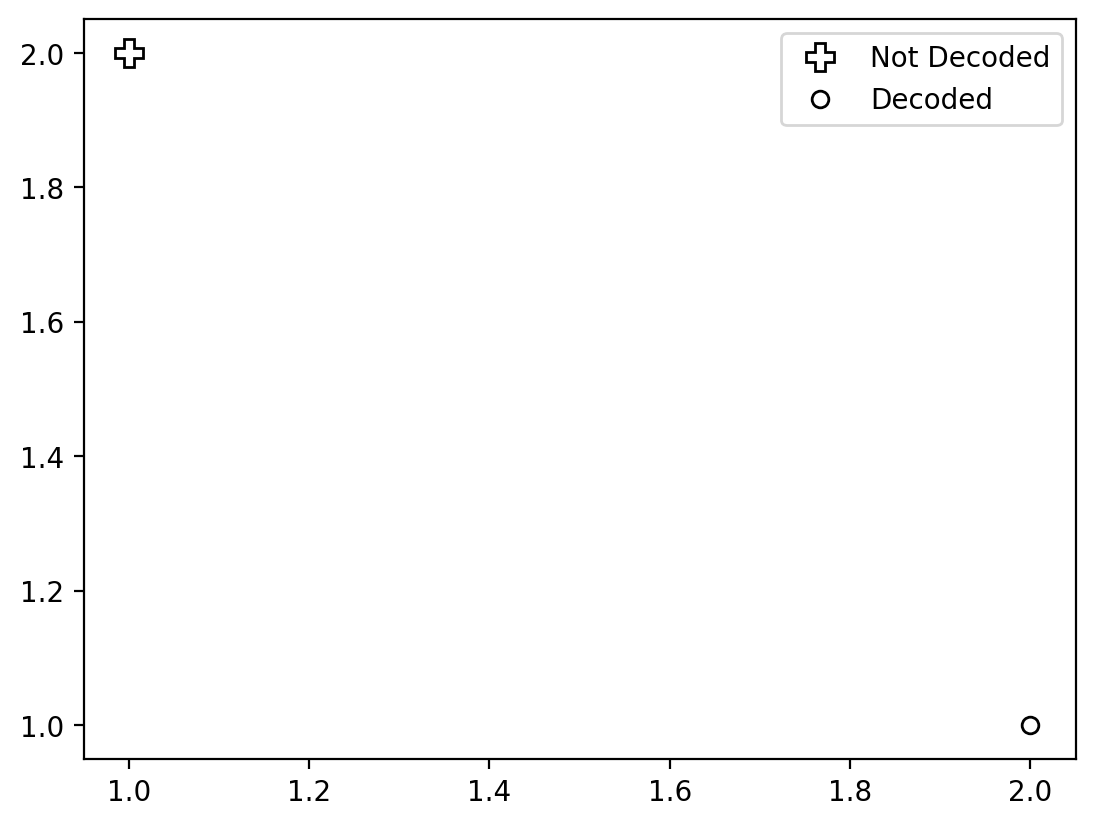

In [23]:
plt.plot(1, 2, linestyle='None',marker='P',markerfacecolor="w", markeredgecolor="k", markersize=10, label="Not Decoded")
plt.plot(2, 1, linestyle='None',marker='.',markerfacecolor="w", markeredgecolor="k", markersize=12, label="Decoded")
plt.legend()

plt.savefig('fig1A_legend.pdf')